## This notebook is to explore Scania Dataset, impute the missing values and apply dimensionality reduction

**Yasmin Fathy <Fathy.Yasmin@gmail.com>**

**Latest Updates: 30/08/2020**

In [1]:
import pandas as pd
import numpy as np
import os
from pprint import pprint

# to display fully (non-truncated) data-frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#pd.set_option('display.max_colwidth', -1)

#Setup to show all results in jupiter not only the last one:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # revert to 'last_expr' to get only last results

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
from pprint import pprint

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (20,20)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

## Evaluation

In [2]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, make_scorer,\
    recall_score, f1_score, precision_recall_curve, log_loss, cohen_kappa_score,roc_curve, auc
from tqdm import tqdm

In [3]:
RANDOM_STATE = 42

**APS Misclasification Cost Function**

In [4]:
def __perform_measure(y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        y_actual = list(y_actual)
        y_hat = list(y_hat)
        for i in range(len(y_hat)):
            if y_actual[i] == y_hat[i] == 1:
                TP += 1
            if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
                FP += 1
            if y_actual[i] == y_hat[i] == 0:
                TN += 1
            if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
                FN += 1

        return [TP, FP, TN, FN]

def custom_cost_fn_loss(y_actual, y_hat):
        [TP, FP, TN, FN] = __perform_measure(y_actual, y_hat)
        # print(len(list(y_actual)),
        #       len(list(y_hat)))
        # cm = confusion_matrix(list(y_actual), list(y_hat))
        # print(len(cm))
        # print(len(cm[0]))
        # print(cm)
        # FP = cm[0][1]
        # FN = cm[1][0]
        return (500 * FN) + (FP * 10)
    
APS_cost_fn = make_scorer(custom_cost_fn_loss, greater_is_better=False)

### ML Model Evalution

- **y** : original label in the testing-set
- **y_predict**: predicted label from the ML algorithm
- **y_predict_prob**: probability output of the algorithm about the minority class

**Plotting the precision, recall curve**

In [5]:
def plot_precession_recall_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='Precision Recall curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Precision Recall curve  '+ str(alg_name))
    plt.legend(loc="lower right")
    plt.show();

In [6]:
def plot_roc_auc_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

**Evaluating the results using a set of metrics**

In [7]:
def model_evaluaiton(y, y_predict, alg_name):        
            print(classification_report(y, list(y_predict)))
            cm = confusion_matrix(y, list(y_predict))
            print(cm)
            print("Accuracy:", accuracy_score(y, y_predict))
            print("roc_auc_score:", roc_auc_score(y, y_predict))
            print("precision_score:", precision_score(y, y_predict))
            print("recall_score:", recall_score(y, y_predict))
            print("f1_score:", f1_score(y, y_predict))
            FP = cm[0][1]
            FN = cm[1][0]
            print("CM: FP", FP)
            print("CM: FN", FN)
            print("APS Cost = ", (500 * FN) + (FP * 10))
            plot_precession_recall_curve(y, y_predict, alg_name)
            plot_roc_auc_curve(y, y_predict, alg_name)

**Finding the threshold that minimises the misclassification of the minority class i.e. class = 1 and apply the best threshold as post-processing steps**

In [8]:
def find_cut_off(y, y_predict_prob):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict_prob)
    min_cost = np.inf
    best_threshold = 0.5
    costs = []
    for threshold in tqdm(thresholds):
        #y_pred_threshold = np.where(scores > threshold, 0, 1)
        y_pred_threshold = y_predict_prob > threshold
        tn, fp, fn, tp = confusion_matrix(y, y_pred_threshold).ravel()
        cost = 10*fp + 500*fn
        costs.append(cost)
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold
    print("Best threshold: {:.4f}".format(best_threshold))
    print("Min cost: {:.2f}".format(min_cost))
    return best_threshold
    

---

## Read training and testing files

In [9]:
data_dir ="ScaniaDataset/dimReduction/"
df_train = pd.read_csv(data_dir+"pca_aps_mean_failure_train_set.csv")
df_test =  pd.read_csv(data_dir+"pca_aps_mean_failure_test_set.csv")

# data_dir ="ScaniaDataset/imputation/"
# df_train = pd.read_csv(data_dir+"imp_aps_mean_failure_training_set.csv")
# df_test =  pd.read_csv(data_dir+"imp_aps_mean_failure_test_set.csv")

In [10]:
df_train["class"].value_counts()

df_test["class"].value_counts()

0    59000
1     1000
Name: class, dtype: int64

0    15625
1      375
Name: class, dtype: int64

In [11]:
df_train.head()
df_test.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,-0.357653,0.149168,0.785559,0.107379,-0.068720,-0.028512,0.128307,0.002902,-0.073669,0.079233,-0.019663,0
1,-0.009868,0.178451,-0.153641,-0.106095,0.115751,0.677376,0.038713,0.021226,0.052543,-0.016909,-0.012898,0
2,0.036263,-0.202770,-0.164386,-0.072079,0.131766,-0.043973,-0.051563,-0.000143,0.000497,-0.034116,-0.000904,0
3,0.207965,-0.419020,-0.145090,-0.048601,-0.000098,-0.007554,-0.008067,0.004260,0.006622,0.011792,-0.001259,0
4,-0.111736,0.259781,-0.174570,-0.061653,-0.000418,-0.020208,0.079826,-0.010607,0.004089,-0.047178,-0.014056,0


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,0.161155,-0.296518,-0.147703,-0.064035,-0.017811,-0.017302,0.001606,0.008635,0.022569,0.004805,-0.000669,0
1,0.197147,-0.390714,-0.145632,-0.052749,-0.003007,-0.008112,-0.006774,0.005026,0.008747,0.010879,-0.000986,0
2,-0.271152,0.611412,-0.183003,-0.143001,-0.002290,-0.010953,0.107131,-0.045472,0.038387,-0.092350,0.044199,0
3,-0.134755,0.120177,-0.180050,-0.094396,0.112898,-0.045628,0.058169,0.005929,0.011544,-0.038997,-0.004686,0
4,0.171726,-0.324381,-0.146679,-0.064361,-0.004982,-0.002021,-0.007429,0.004521,0.007393,0.011175,-0.000230,0


----

## ML Predictive models on the original data: No data generation included

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [13]:
#scoring_fn = "f1_weighted"
scoring_fn = APS_cost_fn

In [14]:
y_train = df_train['class']
y_test = df_test['class']

X_train = df_train.drop(['class'], axis=1)
X_test = df_test.drop(['class'], axis=1)

In [15]:
len(X_train)
len(X_test)

60000

16000

### Logistic Regression

In [16]:
# LR_hyperparameters = dict(C=[0.01, 1, 10, 100],
#                                max_iter=[6000])  # hyperparameter options

# # Best options obtained from running the params mentioned above
LR_hyperparameters = dict(C=[1], max_iter=[6000])  # hyperparameter options

In [17]:
LR_clf = GridSearchCV(LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE),
                               param_grid=LR_hyperparameters, cv=5,
                               verbose=2, scoring=scoring_fn, n_jobs=-1)

LR_best_model = LR_clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.34      0.93      0.50       375

    accuracy                           0.96     16000
   macro avg       0.67      0.94      0.74     16000
weighted avg       0.98      0.96      0.97     16000

[[14949   676]
 [   26   349]]
Accuracy: 0.956125
roc_auc_score: 0.9437013333333335
precision_score: 0.3404878048780488
recall_score: 0.9306666666666666
f1_score: 0.49857142857142867
CM: FP 676
CM: FN 26
APS Cost =  19760


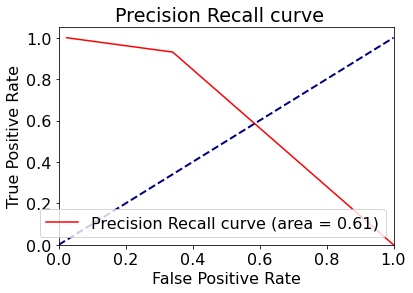

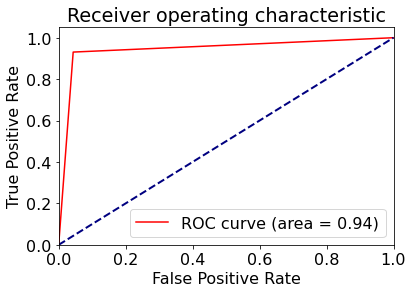

In [18]:
print("Best estimator: ", LR_best_model.best_estimator_)
# X = X.values.reshape(-1, 1)
LR_predict_test = LR_best_model.predict(X_test)
LR_pre_prob_test = LR_best_model.predict_proba(X_test)

model_evaluaiton(y_test, LR_predict_test,"")

**Finding the threshold and then evaluate**
- y_predict_prob_1 : classifier probability's output for minority class

In [19]:
LR_y_predict_prob_1 = LR_pre_prob_test[:,1]
LR_best_th = find_cut_off(y_test, LR_y_predict_prob_1)

100%|██████████| 15598/15598 [09:42<00:00, 26.77it/s] 

Best threshold: 0.3443
Min cost: 16530.00


In [20]:
LR_best_th

0.34434299297340715

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.97      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14622  1003]
 [   13   362]]
Accuracy: 0.9365
roc_auc_score: 0.9505706666666667
precision_score: 0.2652014652014652
recall_score: 0.9653333333333334
f1_score: 0.4160919540229885
CM: FP 1003
CM: FN 13
APS Cost =  16530


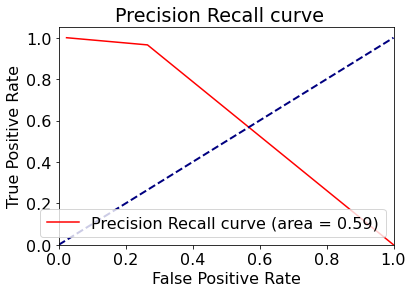

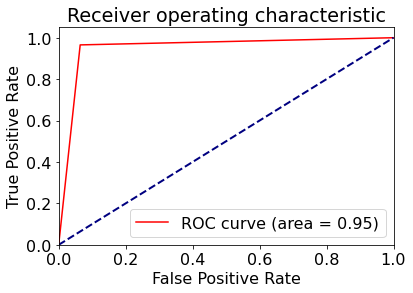

In [21]:
LR_predict_test_th = LR_pre_prob_test[:,1] > LR_best_th

model_evaluaiton(y_test, LR_predict_test_th, "")

**Just example to prove the point of how the threshold works**

In [42]:
(1.0-LR_best_th)
lr_th = round((1.0-LR_best_th),3)
lr_th

0.6556570070265928

0.656

0.6556570070265928

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.26      0.97      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14620  1005]
 [   13   362]]
Accuracy: 0.936375
roc_auc_score: 0.9505066666666667
precision_score: 0.2648134601316752
recall_score: 0.9653333333333334
f1_score: 0.415614236509759
CM: FP 1005
CM: FN 13
APS Cost =  16550


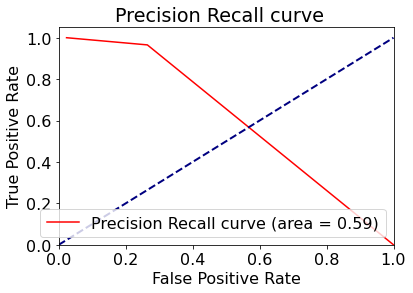

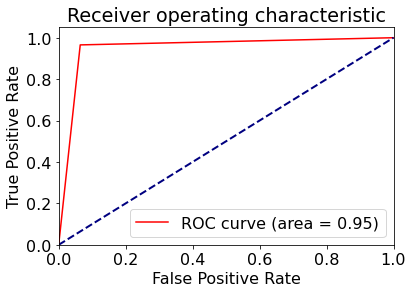

In [65]:
# LR_predict_test_th_2 = LR_pre_prob_test[:,1] >= LR_best_th
# LR_predict_test_th_2 = LR_pre_prob_test[:,0] < (1.0-LR_best_th)
LR_predict_test_th_2 = LR_pre_prob_test[:,0] < lr_th

(1.0-LR_best_th)
model_evaluaiton(y_test, LR_predict_test_th_2, "")

**Evaluate on Training-set**

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     59000
           1       0.26      0.91      0.41      1000

    accuracy                           0.96     60000
   macro avg       0.63      0.93      0.69     60000
weighted avg       0.99      0.96      0.97     60000

[[56441  2559]
 [   90   910]]
Accuracy: 0.95585
roc_auc_score: 0.933313559322034
precision_score: 0.26232343614874604
recall_score: 0.91
f1_score: 0.40724994405907367
CM: FP 2559
CM: FN 90
APS Cost =  70590


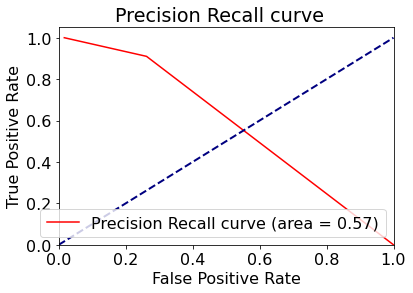

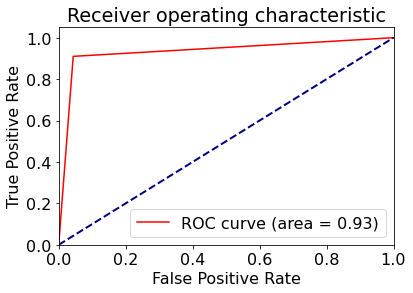

In [24]:
LR_predict_train = LR_best_model.predict(X_train)
LR_pre_prob_train = LR_best_model.predict_proba(X_train)

model_evaluaiton(y_train, LR_predict_train, "")

### Random Forest

In [25]:
# RF_hyperparameters = {
#             'n_estimators': [50, 100, 250],
#              'max_features': ['auto', 'sqrt', 'log2'],
#             # 'max_depth': [5, 6, 8, None],
#             'max_depth': [5, 6, 8],
#             'criterion': ['gini', 'entropy']}

## Best Params based on running the previous range of hyperparameter
RF_hyperparameters = {
                      'n_estimators': [250],
                       'max_depth': [5],
                      'criterion': ['entropy']}

In [26]:
RF_clf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state= RANDOM_STATE),
                               param_grid=RF_hyperparameters, cv=5,
                               verbose=2, scoring=scoring_fn, n_jobs=-1)

RF_best_model = RF_clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.4s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.5s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.95      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.95      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14865   760]
 [   17   358]]
Accuracy: 0.9514375
roc_auc_score: 0.9530133333333334
precision_score: 0.3

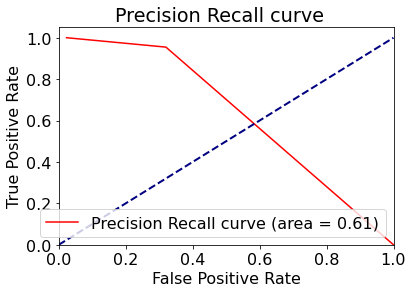

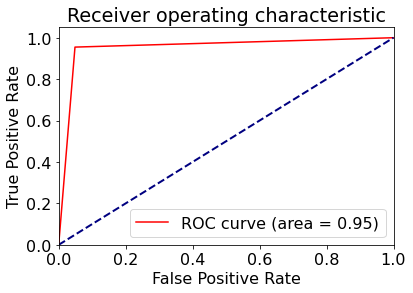

In [27]:
print("Best estimator: ", RF_best_model.best_estimator_)
# X = X.values.reshape(-1, 1)
RF_predict_test = RF_best_model.predict(X_test)
RF_pre_prob_test = RF_best_model.predict_proba(X_test)
model_evaluaiton(y_test,RF_predict_test, "")

**Finding the threshold and then evaluate**
- y_predict_prob_1 : classifier probability's output for minority class

In [28]:
RF_y_predict_prob_1 = RF_pre_prob_test[:,1]
RF_best_th = find_cut_off(y_test, RF_y_predict_prob_1)

100%|██████████| 8977/8977 [05:45<00:00, 25.98it/s]

Best threshold: 0.3017
Min cost: 13710.00


              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.99      0.40       375

    accuracy                           0.93     16000
   macro avg       0.62      0.96      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14504  1121]
 [    5   370]]
Accuracy: 0.929625
roc_auc_score: 0.9574613333333334
precision_score: 0.24815560026827632
recall_score: 0.9866666666666667
f1_score: 0.3965702036441587
CM: FP 1121
CM: FN 5
APS Cost =  13710


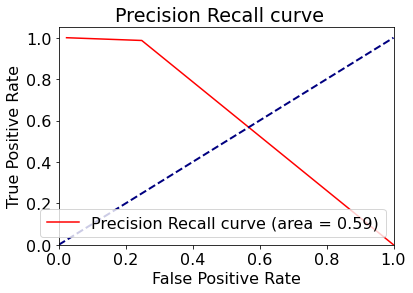

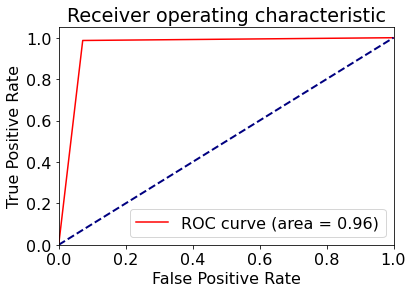

In [29]:
RF_predict_test_th = RF_pre_prob_test[:,1] > RF_best_th
model_evaluaiton(y_test, RF_predict_test_th, "")

**Just example to prove the point of how the threshold works**

In [66]:
(1.0-RF_best_th)
rf_th = round((1.0-RF_best_th),3)
rf_th

0.6983413632779929

0.698

0.6983413632779929

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.99      0.40       375

    accuracy                           0.93     16000
   macro avg       0.62      0.96      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14500  1125]
 [    5   370]]
Accuracy: 0.929375
roc_auc_score: 0.9573333333333335
precision_score: 0.24749163879598662
recall_score: 0.9866666666666667
f1_score: 0.39572192513368987
CM: FP 1125
CM: FN 5
APS Cost =  13750


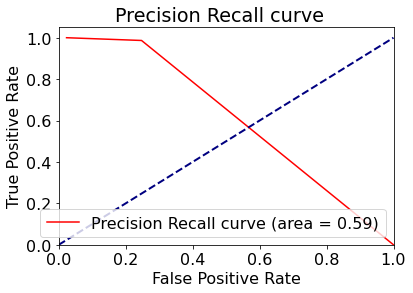

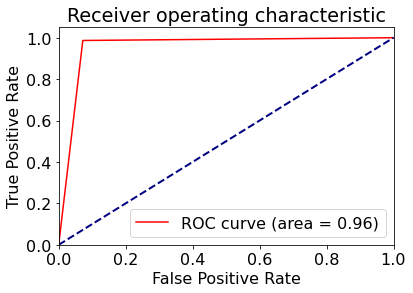

In [70]:
# RF_predict_test_th_2 = RF_pre_prob_test[:,1] >= RF_best_th
# RF_predict_test_th_2 = RF_pre_prob_test[:,0] < (1 - RF_best_th)
RF_predict_test_th_2 = RF_pre_prob_test[:,0] < 0.7

(1 - RF_best_th)
model_evaluaiton(y_test, RF_predict_test_th_2, "")

**Evaluating on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     56091
           1       0.95      0.24      0.39      3909

    accuracy                           0.95     60000
   macro avg       0.95      0.62      0.68     60000
weighted avg       0.95      0.95      0.94     60000

[[56046    45]
 [ 2954   955]]
Accuracy: 0.9500166666666666
roc_auc_score: 0.6217528697097345
precision_s

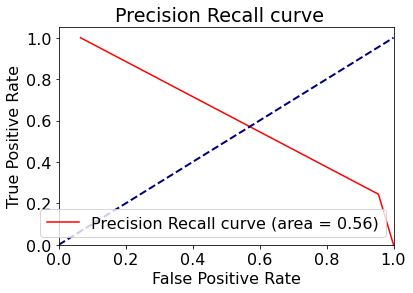

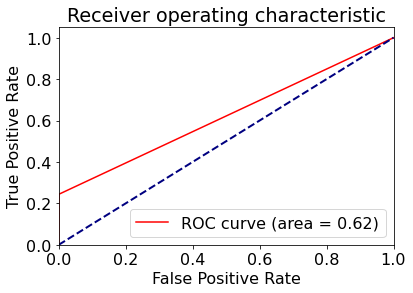

In [32]:
print("Best estimator: ", RF_best_model.best_estimator_)
# X = X.values.reshape(-1, 1)
RF_predict_train = RF_best_model.predict(X_train)
RF_pre_prob_train = RF_best_model.predict_proba(X_train)
model_evaluaiton(RF_predict_train, y_train, "")

## XGBoost

In [33]:
# xg_hyperparameters = {
#                 'max_depth': [3, 4, 5],
#                 'n_estimators': [50, 100],
#                 'learning_rate': [0.1, 0.01, 0.05]
#             }

# best param when PCA is used
xg_hyperparameters = {
                'max_depth': [5],
                'n_estimators': [100],
                'learning_rate': [0.1]
            }

In [34]:
xg_clf = GridSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE),
                                   param_grid=xg_hyperparameters, cv=5,
                                   scoring=scoring_fn, n_jobs=-1,verbose=2)

In [35]:
xgbb = xg_clf.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.5s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.75      0.42      0.54       375

    accuracy                           0.98     16000
   macro avg       0.87      0.71      0.77     16000
weighted avg       0.98      0.98      0.98     16000

[[15573    52]
 [  216   159]]
Accuracy

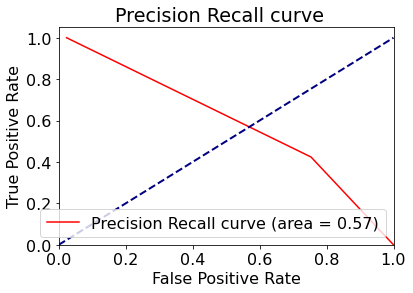

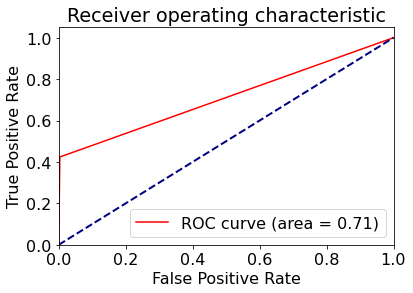

In [36]:
print("Best estimator: ", xgbb.best_estimator_)
# X = X.values.reshape(-1, 1)
xgbb_predict_test = xgbb.predict(X_test)
xgbb_pre_prob_test = xgbb.predict_proba(X_test)
model_evaluaiton(y_test, xgbb_predict_test, "")

**Finding the threshold and then evaluate**
- y_predict_prob_1 : classifier probability's output for minority class

In [37]:
xgbb_y_predict_prob_1 = xgbb_pre_prob_test[:,1]
xgbb_best_th = find_cut_off(y_test, xgbb_y_predict_prob_1)



100%|██████████| 6920/6920 [04:24<00:00, 26.16it/s]

Best threshold: 0.0179
Min cost: 12230.00


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.98      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14852   773]
 [    9   366]]
Accuracy: 0.951125
roc_auc_score: 0.9632640000000001
precision_score: 0.32133450395083407
recall_score: 0.976
f1_score: 0.48348745046235136
CM: FP 773
CM: FN 9
APS Cost =  12230


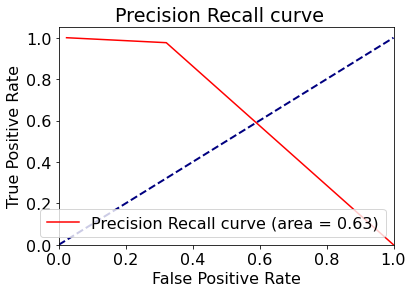

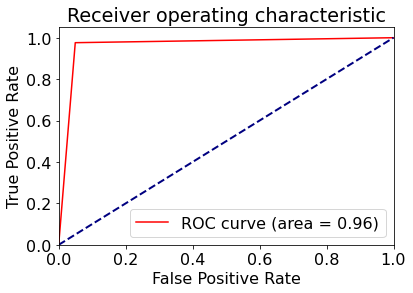

In [38]:
xgbb_predict_test_th = xgbb_pre_prob_test[:,1] > xgbb_best_th

model_evaluaiton(y_test, xgbb_predict_test_th, "")


**Just example to prove the point of how the threshold works**

In [56]:
(1.0-xgbb_best_th)
xg_th = round((1.0-xgbb_best_th),3)
xg_th

0.982055801898241

0.982

0.982055801898241

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.98      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14852   773]
 [    9   366]]
Accuracy: 0.951125
roc_auc_score: 0.9632640000000001
precision_score: 0.32133450395083407
recall_score: 0.976
f1_score: 0.48348745046235136
CM: FP 773
CM: FN 9
APS Cost =  12230


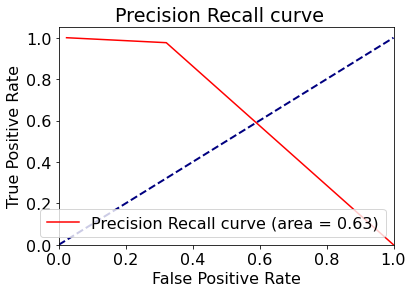

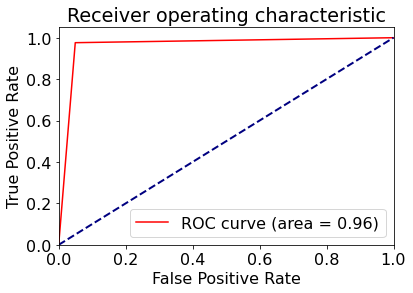

In [72]:
# xgbb_predict_test_th = xgbb_pre_prob_test[:,1] >= xgbb_best_th
# xgbb_predict_test_th = xgbb_pre_prob_test[:,0] < (1 - xgbb_best_th)

xgbb_predict_test_th = xgbb_pre_prob_test[:,0] < xg_th

(1 - xgbb_best_th)
model_evaluaiton(y_test, xgbb_predict_test_th, "")

**Evaluating on Training-set**

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     59000
           1       0.91      0.58      0.71      1000

    accuracy                           0.99     60000
   macro avg       0.95      0.79      0.85     60000
weighted avg       0.99      0.99      0.99     60000

[[58944    56]
 [  415   585]]
Accuracy: 0.99215
roc_auc_score: 0.7920254237288136
precision_score: 0.9126365054602185
recall_score: 0.585
f1_score: 0.712979890310786
CM: FP 56
CM: FN 415
APS Cost =  208060


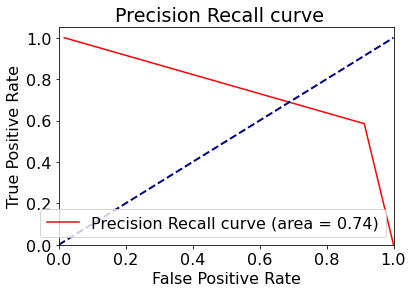

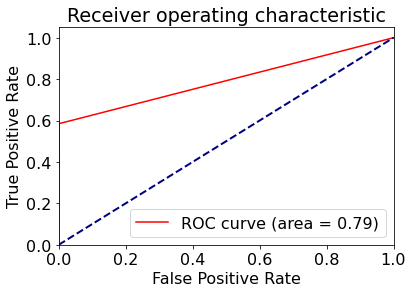

In [41]:
xgbb_predict_train = xgbb.predict(X_train)
xgbb_pre_prob_train = xgbb.predict_proba(X_train)
model_evaluaiton(y_train, xgbb_predict_train ,"")

-----